# 📊 Unsupervised Deep Learning: Gaussian Mixture Models & EM-Based Collaborative Filtering

Welcome to this comprehensive course on **Unsupervised Deep Learning**, designed and instructed by **Aditya Saxena**. This course explores the fascinating domain of unsupervised learning, where algorithms discover hidden patterns in data without labeled outputs. You will learn to apply mathematical and algorithmic techniques to understand clustering, probability distributions, and latent variable models—all essential for data-driven decision-making in modern machine learning systems.

The course focuses on practical implementation and theory behind **Gaussian Mixture Models (GMMs)** and the **Expectation-Maximization (EM) algorithm**, culminating in a real-world application: collaborative filtering and matrix completion using the Netflix dataset. By the end of this journey, you will have built a recommendation system from the ground up using probabilistic principles and iterative optimization techniques. This notebook series is structured modularly, includes two mini-projects per module, and emphasizes interpretability, evaluation, and reproducibility.

## 📓 Course Modules
Each module consists of structured Jupyter Notebooks with explanations, derivations, code walkthroughs, and mini-projects.

* Module 01: Introduction to Unsupervised Learning
* Module 02: K-Means Clustering
* Module 03: Gaussian Mixture Models (GMMs)
* Module 04: Expectation-Maximization (EM) Algorithm
* Module 05: EM for Matrix Completion (Netflix Data)
* Module 06: Log-Domain Calculations & Stability
* Module 07: BIC for Model Selection
* Module 08: Completing Missing Entries
* Module 09: Evaluation using RMSE & Model Interpretability
* Module 10: Final Project & Case Study Walkthrough

In [8]:
# 📦 INSTALL & IMPORT: One-time Setup Cell for the Entire Project

# --- Install required libraries if not already available ---
# !pip install numpy pandas matplotlib seaborn scikit-learn scipy --quiet

# --- Import necessary libraries with detailed comments ---

# NumPy and Pandas: For numerical computations and structured data manipulation
import numpy as np                  # For array operations, statistics, linear algebra
import pandas as pd                 # For handling structured data (CSV, tables)

# Matplotlib and Seaborn: For visualizations
import matplotlib.pyplot as plt    # Core plotting library
import seaborn as sns              # Beautiful, high-level statistical plots

# Scikit-learn modules for clustering, dimensionality reduction, and evaluation
from sklearn.datasets import make_blobs              # Synthetic dataset generator
from sklearn.cluster import KMeans                   # K-Means clustering
from sklearn.mixture import GaussianMixture          # GMM clustering
from sklearn.decomposition import PCA                # Dimensionality reduction
from sklearn.metrics import silhouette_score, mean_squared_error  # Evaluation metrics

# Preprocessing tools
from sklearn.preprocessing import StandardScaler     # Normalize features
from sklearn.impute import SimpleImputer             # Handle missing values

# Log-sum-exp for numerical stability in EM algorithm
from scipy.special import logsumexp                  # Stable log of summed exponentials

# Miscellaneous utilities
import warnings
warnings.filterwarnings("ignore")                    # Suppress warning messages

# Jupyter magic command (must not have inline comments)
%matplotlib inline

# Global plotting configuration
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

print("✅ All required libraries are successfully imported.")


✅ All required libraries are successfully imported.


## 📐 Theoretical Foundation

Unsupervised learning assumes a dataset of \( n \) points:

$$
X = \{x_1, x_2, \dots, x_n\}, \quad x_i \in \mathbb{R}^d
$$

There are no corresponding labels \( y_i \). Instead, we assume there exists some **underlying structure** or **distribution** that governs the data. A key probabilistic model we explore is the **Gaussian Mixture Model (GMM)**, defined as:

$$
p(x) = \sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x \mid \mu_j, \Sigma_j)
$$

Where:

$$
\begin{aligned}
\pi_j &\quad \text{Mixing coefficient (prior probability of component } j) \\\\
\mu_j &\quad \text{Mean vector of the } j\text{th Gaussian} \\\\
\Sigma_j &\quad \text{Covariance matrix of the } j\text{th Gaussian} \\\\
\sum_{j=1}^{K} \pi_j &= 1
\end{aligned}
$$

The learning objective is to estimate:

$$
\left\{ \pi_j, \mu_j, \Sigma_j \right\}_{j=1}^{K}
$$

that maximize the likelihood function:

$$
\mathcal{L}(\theta; X) = \prod_{i=1}^{n} \sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x_i \mid \mu_j, \Sigma_j)
$$

This provides the foundation for the **Expectation-Maximization (EM)** algorithm, which we’ll explore in depth.


### 🔹 Step 1.1: Load and Visualize Toy Dataset

**Motivation:**  
Before fitting clustering models, it's essential to understand the structure and scale of the dataset. Visualizing the raw data gives us clues about potential cluster shapes, separations, and noise levels.

**Inputs:**  
- `toy_data.txt`: A 2D dataset of shape \( (n, 2) \) where each row is a point in \(\mathbb{R}^2\)

**Expected Output:**  
- Shape of the data matrix
- First 5 data points (preview)



In [7]:
# 📥 Load dataset from local text file
X = np.loadtxt("dataset/toy_data.txt")

# Preview the shape and first few entries
print(f"✅ Data shape: {X.shape}")
print("🔍 First 5 rows:\n", X[:5])


✅ Data shape: (250, 2)
🔍 First 5 rows:
 [[-1.636  2.413]
 [-2.957  2.296]
 [-2.871  1.832]
 [-2.696  1.327]
 [-2.272  1.738]]


### 🔍 Inference

The dataset contains **250 two-dimensional points**, suggesting a well-sized sample for visual exploratory clustering. The first five points indicate that the data is likely centered around a negative \( x \)-axis range and a positive \( y \)-axis range. This may hint at compact, possibly elliptical clusters, typical of Gaussian sources. These insights justify our use of algorithms like GMM and K-Means in the upcoming modules.


### 🔹 Step 1.2: Visualize the 2D Dataset

**Motivation:**  
Visualizing the dataset in two dimensions allows us to inspect natural groupings, density clusters, and spatial separation. This forms a foundation for clustering intuition and helps guide parameter selection, such as the number of clusters.

**Inputs:**  
- $$ X \in \mathbb{R}^{250 \times 2} $$

**Expected Output:**  
- A scatter plot showing the spatial distribution of all 250 points.


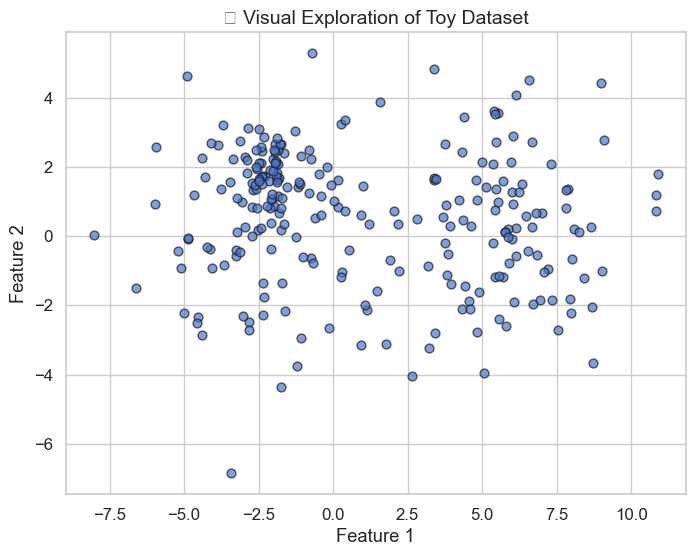

In [9]:
# Scatter plot of the 2D dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=40, edgecolor='k', alpha=0.7)
plt.title("🔍 Visual Exploration of Toy Dataset", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


### 📌 Interpretation

As we can see in the scatter plot above, the data does not appear to be spread out uniformly. There are dense regions and apparent gaps, suggesting that the data might have originated from a few distinct groups or clusters.

This observation aligns with one of the core goals of unsupervised learning — identifying hidden patterns in unlabelled data. Although we do not yet know how many clusters exist or where they are, the plot hints at separability, making it a good candidate for clustering techniques such as **K-Means** or **Gaussian Mixture Models**.

Let’s now move forward to clustering this data using **K-Means**, starting with initialization and iteration mechanics.


## 📐 Theoretical Foundation

K-Means clustering partitions a dataset into \( K \) groups by minimizing the within-cluster variance. The input dataset is represented as:

$$
X \in \mathbb{R}^{n \times d}
$$

The algorithm aims to minimize the following objective function:

$$
\underset{C_1, \dots, C_K}{\text{minimize}} \sum_{j=1}^{K} \sum_{x_i \in C_j} \|x_i - \mu_j\|^2
$$

---

### 📌 Definitions

$$
\begin{aligned}
C_j &:\quad \text{Set of data points assigned to cluster } j \\\\
\mu_j &:\quad \text{Centroid (mean) of cluster } j \\\\
\|x_i - \mu_j\|^2 &:\quad \text{Squared Euclidean distance between } x_i \text{ and } \mu_j
\end{aligned}
$$

---

### 🔁 Iterative Algorithm Steps

1. **Assignment Step**:

$$
c_i = \arg\min_{j \in \{1, 2, \dots, K\}} \|x_i - \mu_j\|^2
$$

2. **Update Step**:

$$
\mu_j = \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i
$$

The process is repeated until convergence—when cluster assignments stop changing or the centroids become stable.


### 🔹 Step 2.1.1: K-Means Initialization and Visualization

**Motivation:**  
Now that we understand the theoretical foundation of K-Means, let's run the algorithm on our toy dataset. We'll start with a small value of \( K = 3 \), which seems reasonable based on the previous scatter plot.

We'll initialize and fit the K-Means model, then visualize the clusters it finds. This helps us understand how K-Means separates the data spatially and where it places the centroids.

**Inputs:**  
- Data matrix:  
  $$
  X \in \mathbb{R}^{250 \times 2}
  $$
- Hyperparameter:  
  $$
  K = 3
  $$

**Expected Output:**  
- A scatter plot showing:
  - Clustered points (color-coded)
  - Centroids marked clearly


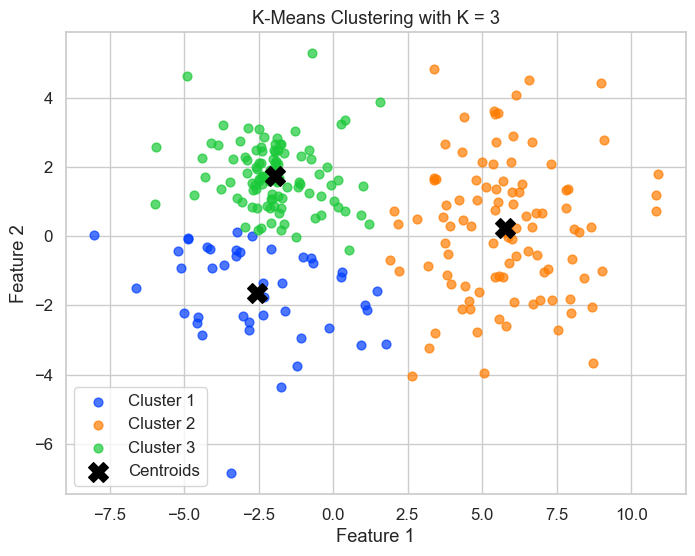

In [11]:
# Initialize and fit K-Means with K = 3
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Plot clusters with centroids
plt.figure(figsize=(8, 6))
palette = sns.color_palette("bright", 3)
for i in range(3):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], s=40, color=palette[i], label=f"Cluster {i+1}", alpha=0.7)

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='black', marker='X', label='Centroids')

plt.title("K-Means Clustering with K = 3")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


### 🔹 Step 2.1.2: Visualize K-Means Results for K = 1 to 6

**Motivation:**  
Before committing to an optimal value of \( K \), it’s useful to visualize how K-Means behaves for a range of cluster counts. This helps build intuition about:
- Underfitting (too few clusters),
- Overfitting (too many clusters), and
- The qualitative structure of the dataset.

**Inputs:**  
- Fixed dataset \( X \in \mathbb{R}^{250 \times 2} \)
- Varying \( K \in \{1, 2, 3, 4, 5, 6\} \)

**Expected Output:**  
- 6 scatter plots (1 for each \( K \)) showing cluster assignments and centroids.


### 📌 Interpretation

The plot above shows the result of applying K-Means with \( K = 3 \). We can see that the data points have been partitioned into three distinct clusters, each marked with a unique color. The **centroids**, represented by black "X" markers, are located at the geometric centers of their respective clusters.

This demonstrates the key behavior of K-Means: each iteration pulls centroids toward the dense regions of their assigned points and reassigns points based on proximity to updated centroids. Visually, the clusters appear compact and well-separated, indicating that the initial choice of \( K = 3 \) is a good starting point for modeling this dataset.

In upcoming steps, we’ll examine how to assess and fine-tune the value of \( K \) using metrics like **inertia**, **elbow method**, and **silhouette score**.


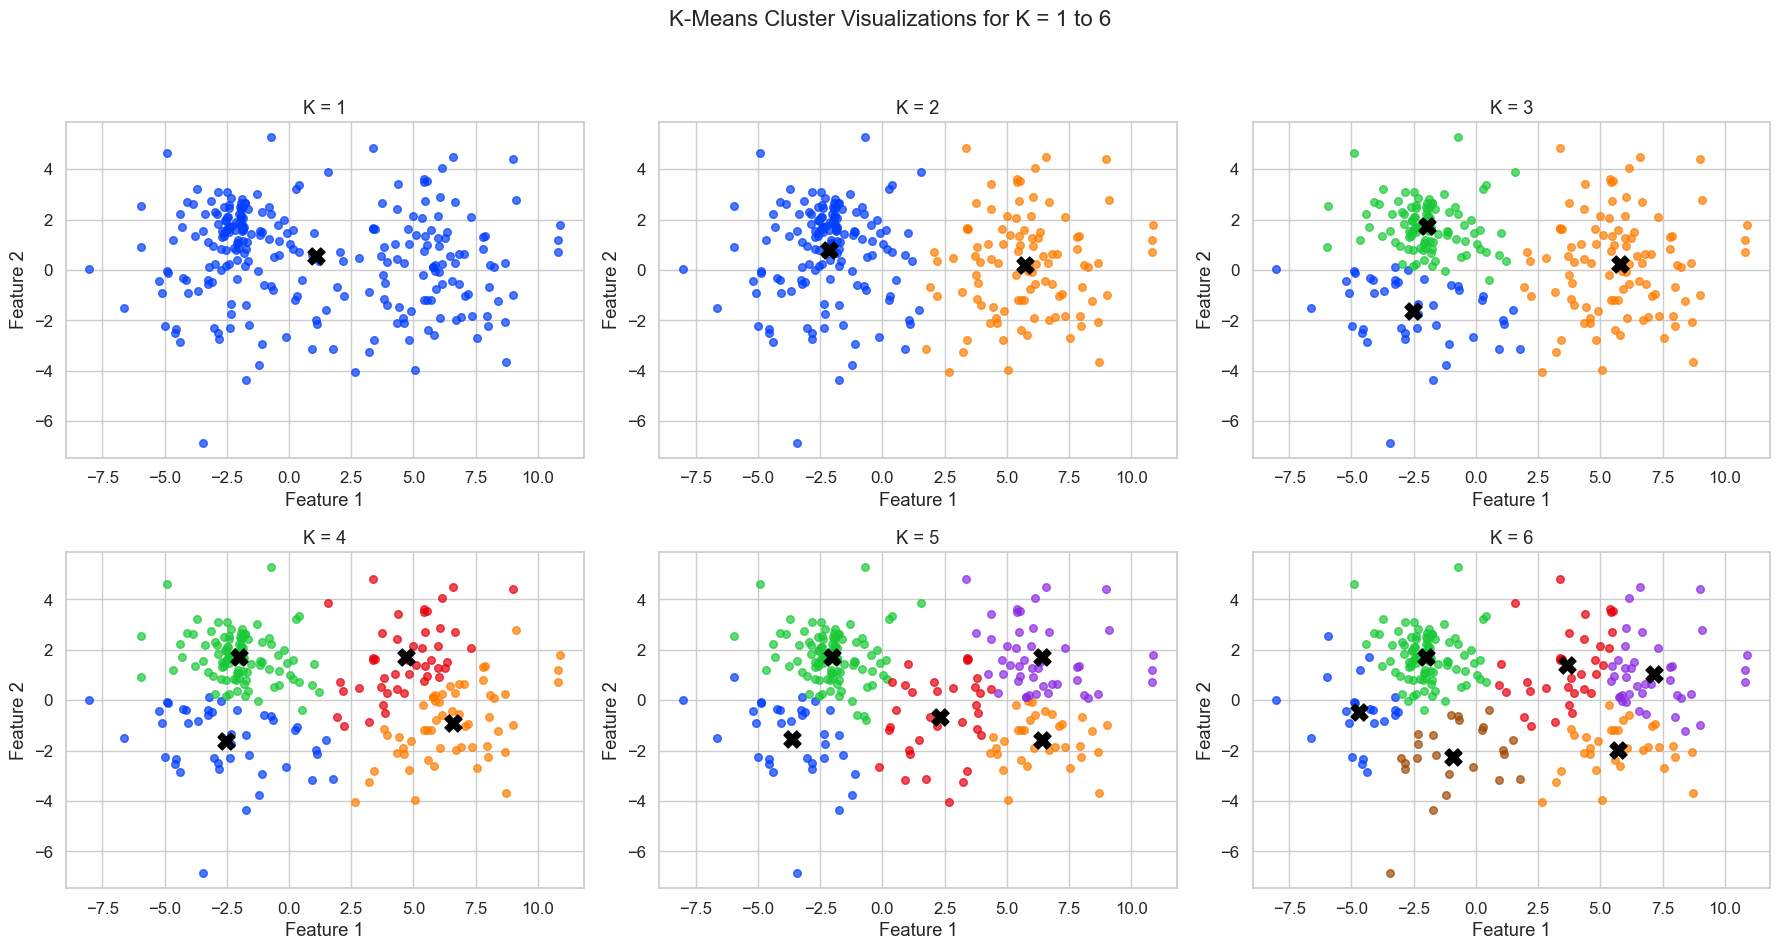

In [13]:
# Visualize K-Means results for K = 1 to 6
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
K_values = range(1, 7)
palette = sns.color_palette("bright", 6)

for i, k in enumerate(K_values):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    centers = km.cluster_centers_
    
    ax = axes[i // 3, i % 3]
    for j in range(k):
        ax.scatter(X[labels == j, 0], X[labels == j, 1], 
                   s=30, label=f"Cluster {j+1}", color=palette[j], alpha=0.7)
    ax.scatter(centers[:, 0], centers[:, 1], s=150, c='black', marker='X', label='Centroid')
    ax.set_title(f"K = {k}")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.grid(True)

plt.suptitle("K-Means Cluster Visualizations for K = 1 to 6", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 📌 Interpretation

These visualizations help us compare how K-Means partitions the dataset for different values of \( K \) ranging from 1 to 6.

- For \( K = 1 \), all data is forced into a single cluster—this leads to underfitting and high inertia.
- As we increase \( K \), clusters start to form around the natural groupings in the data. At \( K = 2 \), we begin to see some separation, but it's incomplete.
- At \( K = 3 \), the clustering aligns well with the visual intuition from our initial scatter plot, revealing three clear groupings.
- Increasing to \( K = 4, 5, 6 \) further splits the clusters, possibly overfitting the data by capturing finer local variations.

This visual progression reinforces the need to balance simplicity and expressiveness. It also demonstrates that selecting \( K \) is not just a statistical task, but one that benefits from interpretability and domain context—both crucial in real-world applications.


### 🔹 Step 2.2: Evaluate Inertia and Plot the Elbow Curve

**Motivation:**  
Although \( K = 3 \) visually appears reasonable, it's essential to justify our choice quantitatively. The **Elbow Method** is a commonly used technique to determine the optimal number of clusters in K-Means.

The idea is to run K-Means for different values of \( K \), calculate the **inertia** (within-cluster sum of squares), and look for the "elbow point"—where the rate of decrease sharply slows.

**Inputs:**  
- Cluster counts:  
  $$
  K = 1, 2, \dots, 10
  $$

**Expected Output:**  
- Line plot showing inertia vs. number of clusters
- Elbow point suggestion for optimal \( K \)


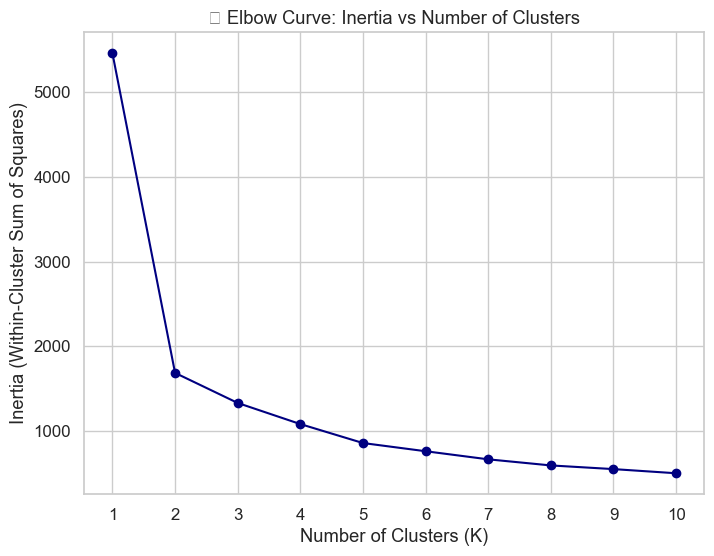

In [12]:
# Evaluate K from 1 to 10 using inertia
inertias = []
K_range = range(1, 11)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertias.append(model.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, marker='o', linestyle='-', color='navy')
plt.title("📉 Elbow Curve: Inertia vs Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.xticks(K_range)
plt.show()


### 📌 Interpretation

The Elbow Curve above illustrates how inertia (within-cluster sum of squares) decreases as the number of clusters \( K \) increases. Initially, adding more clusters leads to a sharp drop in inertia, but after a certain point, the marginal gain reduces significantly.

This turning point or “elbow” is typically considered the optimal number of clusters. In this plot, the elbow appears to occur at around \( K = 3 \), which aligns with our earlier visual analysis. Beyond this point, the improvement in clustering quality becomes less significant, indicating diminishing returns.

This method provides a practical, visual heuristic for selecting \( K \), and forms the basis for evaluating more complex clustering strategies and model selection criteria like BIC or silhouette scores.
